# Scrittura con TFRecord

In [1]:
import numpy
import scipy.io
import tensorflow as tf

percorso1 = "/home/protoss/Documenti/TESI/DATI/in_O2LH_01_0059_.mat"
percorso2 = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quad8192.mat"
percorso3 = '/home/protoss/Documenti/TESI/DATI/TFR/in_O2LH_01_0059.tfrecords'

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def leggi_scrivi(percorsoDati, percorsoQuad, percorsoOut):

    #carico file dati
    struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']
    tempi = struttura['peaks'][0,0][0].astype(numpy.float32)
    frequenze = struttura['peaks'][0,0][1].astype(numpy.float32)
    pesi = (struttura['peaks'][0,0][4]+1).astype(numpy.float32)

    #nb: picchi ha 0-tempi
    #              1-frequenze
    #              2-pesi

    #headers vari
    securbelt = 4000*3

    #frequenze
    stepFrequenza = struttura['basic_info'][0,0]['run'][0,0]['fr'][0,0]['dnat'][0,0][0,0]
    enhancement = 10
    stepFreqRaffinato =  stepFrequenza/enhancement
    freqMin = numpy.amin(frequenze)
    freqMax = numpy.amax(frequenze)
    freqIniz = freqMin- stepFrequenza/2 - stepFreqRaffinato
    freqFin = freqMax + stepFrequenza/2 + stepFreqRaffinato
    nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt
    print(freqMin, freqMax)
    #tempi
    #epoca definita come mediana di tempi di tutto il run
    epoca = (57722+57874)/2

    #spindowns
    spindownMin = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['min'][0,0][0,0]
    spindownMax = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['max'][0,0][0,0]
    stepSpindown = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['dnat'][0,0][0,0]
    nstepSpindown = 100 #WARNING DA DEFINIRE MEGLIO GLI SPINDOWN

    #per doppler corr
    veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:].astype(numpy.float32)
    nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
    primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]

    quadrato = scipy.io.loadmat(percorsoQuad)['quad'].astype(numpy.float32)
    
    print(tempi, epoca, stepFreqRaffinato)
    
#Qui scrittura

    writer = tf.python_io.TFRecordWriter(percorsoOut)

    example = tf.train.Example(features = tf.train.Features(feature=
    {
        #peakmap
        'tempi': _bytes_feature(tempi.tostring()),
        'frequenze': _bytes_feature(frequenze.tostring()),
        'pesi': _bytes_feature(pesi.tostring()),
        #headers: securbelt
        'securbelt': _int64_feature(securbelt),
        #freq
        'stepFreqRaffinato': _float_feature(stepFreqRaffinato),
        'freqIniz': _float_feature(freqIniz),
        'nstepFrequenze': _float_feature(nstepFrequenze),
        #tempi
        'epoca': _float_feature(epoca),
        #sd
        'spindownMin': _float_feature(spindownMin),
        'stepSpindown': _float_feature(stepSpindown),
        'nstepSpindown': _float_feature(nstepSpindown),
        #doppler corr
        'veloc': _bytes_feature(veloc.tostring()),
        'nTempi': _int64_feature(nTempi),
        'primoTempo': _int64_feature(primoTempo),
        'quadrato': _bytes_feature(quadrato.tostring())
    }))
    example_str = example.SerializeToString()
    writer.write(example_str)
    writer.close()
    return tempi

leggi_scrivi(percorso1,percorso2,percorso3)

58.9882 60.0114
[ 57722.73046875  57722.73046875  57722.73046875 ...,  57744.96484375
  57744.96484375  57744.96484375] 57798.0 1.220703125e-05


array([ 57722.73046875,  57722.73046875,  57722.73046875, ...,
        57744.96484375,  57744.96484375,  57744.96484375], dtype=float32)

# Lettura da TFRecord

In [2]:
import numpy
import scipy.io
import tensorflow as tf

tfr_in1 = '/home/protoss/Documenti/TESI/DATI/TFR/in_O2LH_01_0010.tfrecords'
tfr_in2 = '/home/protoss/Documenti/TESI/DATI/TFR/in_O2LH_01_0059.tfrecords'

queue = [tfr_in1,tfr_in2]
print(queue)

['/home/protoss/Documenti/TESI/DATI/TFR/in_O2LH_01_0010.tfrecords', '/home/protoss/Documenti/TESI/DATI/TFR/in_O2LH_01_0059.tfrecords']


In [3]:

def read_and_decode_single_example(filename):
    # first construct a queue containing a list of filenames.
    # this lets a user split up there dataset in multiple files to keep
    # size down
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    # Unlike the TFRecordWriter, the TFRecordReader is symbolic
    reader = tf.TFRecordReader()
    # One can read a single serialized example from a filename
    # serialized_example is a Tensor of type string.
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'tempi': tf.FixedLenFeature([], tf.string),
            'frequenze': tf.FixedLenFeature([], tf.string),
            'pesi': tf.FixedLenFeature([], tf.string),
            #headers: securbelt
            'securbelt': tf.FixedLenFeature([], tf.int64),
            #freq
            'stepFreqRaffinato': tf.FixedLenFeature([], tf.float32),
            'freqIniz': tf.FixedLenFeature([], tf.float32),
            'nstepFrequenze': tf.FixedLenFeature([], tf.float32),
            #tempi
            'epoca': tf.FixedLenFeature([], tf.float32),
            #sd
            'spindownMin': tf.FixedLenFeature([], tf.float32),
            'stepSpindown': tf.FixedLenFeature([], tf.float32),
            'nstepSpindown': tf.FixedLenFeature([], tf.float32),
            #doppler corr
            'veloc': tf.FixedLenFeature([], tf.string),
            'nTempi': tf.FixedLenFeature([], tf.int64),
            'primoTempo': tf.FixedLenFeature([], tf.int64),
            'quadrato': tf.FixedLenFeature([], tf.string)
        })
    # now return the converted data
    
    tempi = tf.decode_raw(features['tempi'], tf.float32)
    frequenze = tf.decode_raw(features['frequenze'], tf.float32)
    pesi = tf.decode_raw(features['pesi'], tf.float32)
    
    securbelt = features['securbelt']
    
    stepFreqRaffinato = features['stepFreqRaffinato']
    freqIniz = features['freqIniz']
    nstepFrequenze = features['nstepFrequenze']
    
    epoca = features['epoca']
    
    spindownMin = features['spindownMin']
    stepSpindown = features['stepSpindown']
    nstepSpindown = features['nstepSpindown']
    
    veloc = tf.decode_raw(features['veloc'], tf.float32)
    nTempi = features['nTempi']
    primoTempo = features['primoTempo']
    quadrato = features['quadrato']
    
    
    return tempi, frequenze, pesi, securbelt, stepFreqRaffinato, freqIniz, nstepFrequenze, epoca, spindownMin, stepSpindown, nstepSpindown, veloc, nTempi, primoTempo, quadrato

In [10]:
# returns symbolic label and image
tempi, frequenze, pesi, securbelt, stepFreqRaffinato, freqIniz, nstepFrequenze, epoca, spindownMin, stepSpindown, nstepSpindown, veloc, nTempi, primoTempo, quadrato = read_and_decode_single_example(tfr_in2)
#tempismo = tf.decode_raw(tempiRaw, tf.float32)
sessione = tf.Session()

# Required. See below for explanation
init = tf.global_variables_initializer()
sessione.run(init)
tf.train.start_queue_runners(sess=sessione)

# grab examples back.
# first example from file
tempi, frequenze, pesi, securbelt, stepFreqRaffinato, freqIniz, nstepFrequenze, epoca, spindownMin, stepSpindown, nstepSpindown, veloc, nTempi, primoTempo, quadrato = sessione.run([tempi, frequenze, pesi, securbelt, stepFreqRaffinato, freqIniz, nstepFrequenze, epoca, spindownMin, stepSpindown, nstepSpindown, veloc, nTempi, primoTempo, quadrato])
# second example from file
#label_val_2, image_val_2 = sess.run([label, image])


In [11]:
print(securbelt)

12000


# Testing dei valori

In [12]:

# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = frequenze-freqIniz
frequenze = (frequenze/stepFreqRaffinato)-round(10/2+0.001)

tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)
#tempi = numpy.round(tempi/1e8)*1e8

#nstepSpindown = 85
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)

# così ho i tre array delle tre grandezze, 
#più i pesi e la fascia di sicurezza

Tensor("Const_7:0", shape=(106736,), dtype=float32) Tensor("Const_8:0", shape=(106736,), dtype=float32) Tensor("Const_9:0", shape=(100,), dtype=float32) Tensor("Const_10:0", shape=(106736,), dtype=float32)
0.13338088989257812


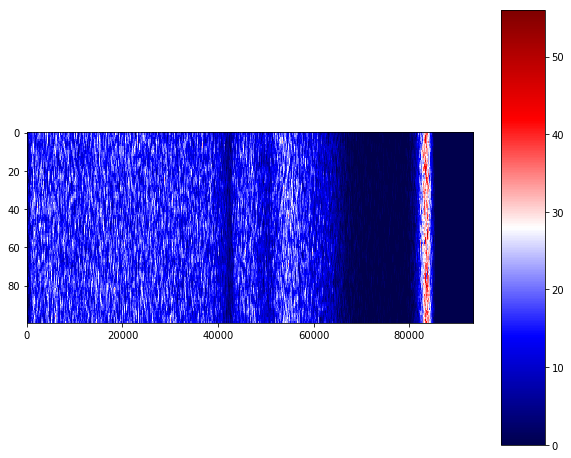

In [13]:
import tensorflow as tf
from tensorflow.python.client import timeline
import time

#ora uso Tensorflow
securbelt = tf.constant([securbelt],dtype=tf.float32)
tempi = tf.constant(tempi,dtype=tf.float32)
pesi = tf.constant(pesi,dtype=tf.float32)
spindowns = tf.constant(spindowns, dtype=tf.float32)
frequenze = tf.constant(frequenze, dtype=tf.float32)

print(tempi,pesi,spindowns,frequenze)

nRows = tf.constant(nstepSpindown, dtype=tf.int32)
nColumns = nstepFrequenze

pesi = tf.reshape(pesi,(1,tf.size(pesi)))
pesi = pesi[0]

def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindowns[stepIesimo], tempi, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenze-sdTimed+securbelt/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.unsorted_segment_sum(pesi, appoggio, nColumns)

#    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)
    
#    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return valori

imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

sessione = tf.Session(config=tf.ConfigProto(log_device_placement=True))

run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

start = time.time()
image = sessione.run(imagenonVar, options=run_options, run_metadata=run_metadata)
stop = time.time()
print(stop-start)


    # Create the Timeline object, and write it to a json
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open('timelinenonVar.json', 'w') as f:
	f.write(ctf)

nColumns = nColumns.astype(int)
semiLarghezza = numpy.round(10/2+0.001).astype(int)
image[:,semiLarghezza*2:nColumns]=image[:,semiLarghezza*2:nColumns]-image[:,0:nColumns - semiLarghezza*2]
image = numpy.cumsum(image, axis = 1)

from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(image[:,1000:nColumns-1500],cmap="seismic", aspect = 400)
pyplot.colorbar(shrink = 1,aspect = 10)


# Prova netcdf4

In [1]:
import numpy
import scipy.io
import tensorflow as tf

percorso1 = "/home/protoss/Documenti/TESI/DATI/in_O2LH_01_0059_.mat"
percorso2 = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quad8192.mat"
percorso3 = '/home/protoss/Documenti/TESI/DATI/TFR/in_O2LH_01_0059.tfrecords'

def leggi(percorsoDati, percorsoQuad):

    #carico file dati
    struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']
    tempi = struttura['peaks'][0,0][0].astype(numpy.float32)
    frequenze = struttura['peaks'][0,0][1].astype(numpy.float32)
    pesi = (struttura['peaks'][0,0][4]+1).astype(numpy.float32)

    #nb: picchi ha 0-tempi
    #              1-frequenze
    #              2-pesi

    #headers vari
    securbelt = 4000*3

    #frequenze
    stepFrequenza = struttura['basic_info'][0,0]['run'][0,0]['fr'][0,0]['dnat'][0,0][0,0]
    enhancement = 10
    stepFreqRaffinato =  stepFrequenza/enhancement
    freqMin = numpy.amin(frequenze)
    freqMax = numpy.amax(frequenze)
    freqIniz = freqMin- stepFrequenza/2 - stepFreqRaffinato
    freqFin = freqMax + stepFrequenza/2 + stepFreqRaffinato
    nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt
    
    #tempi
    #da definire epoca come mediana di tempi di tutto il run
    epoca = (57722+57874)/2
    
    #spindowns
    spindownMin = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['min'][0,0][0,0]
    spindownMax = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['max'][0,0][0,0]
    stepSpindown = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['dnat'][0,0][0,0]
    nstepSpindown = 100 #WARNING DA DEFINIRE MEGLIO GLI SPINDOWN

    #per doppler corr
    veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:].astype(numpy.float32)
    nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
    primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]


    #percorsoIn = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadrato4096Quad.mat"
    quadrato = scipy.io.loadmat(percorsoQuad)['quad']
    
    dizionario = {
        #peakmap
        'tempi': tempi.tostring(),
        'frequenze': frequenze.tostring(),
        'pesi': pesi.tostring(),
        #headers: securbelt
        'securbelt': securbelt,
        #freq
        'stepFreqRaffinato': stepFreqRaffinato,
        'freqIniz': freqIniz,
        'nstepFrequenze': nstepFrequenze,
        #tempi
        'epoca': epoca,
        #sd
        'spindownMin': spindownMin,
        'stepSpindown': stepSpindown,
        'nstepSpindown': nstepSpindown,
        #doppler corr
        'veloc': veloc.tostring(),
        'nTempi': nTempi,
        'primoTempo': primoTempo,
        'quadrato': quadrato
    }
    return dizionario

print(leggi(percorso1,percorso2))

{'tempi': array([ 57722.73046875,  57722.73046875,  57722.73046875, ...,
        57744.96484375,  57744.96484375,  57744.96484375], dtype=float32), 'pesi': array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), 'quadrato': array([[   4.89389987,   34.86477833, -260.20858524]]), 'primoTempo': 57722, 'freqIniz': 58.988085937500003, 'stepFreqRaffinato': 1.2207031250000001e-05, 'securbelt': 12000, 'nstepFrequenze': 95832.0, 'veloc': array([[ -9.39236808e-05,  -9.36657939e-05,  -9.34605681e-05, ...,
         -9.90371227e-05,  -9.92168943e-05,  -9.94628830e-05],
       [  3.18329779e-05,   3.18971982e-05,   3.20401917e-05, ...,
         -1.30770637e-05,  -1.28993120e-05,  -1.27893368e-05],
       [  1.42457311e-05,   1.42142645e-05,   1.41828764e-05, ...,
         -5.88871605e-06,  -5.92149266e-06,  -5.95415967e-06]]), 'spindownMin': -1.0005077053326475e-08, 'frequenze': array([ 58.98962402,  58.9921875 ,  58.99572754, ...,  59.99865723,
        60.00390625,  60.00878906], dtype=float32)

In [7]:
from netCDF4 import Dataset

datasette = Dataset("prova.nc","w",format="NETCDF4")

#gruppoDati = datasette.createGroup("arrais")
#gruppoHeaders = datasette.createGroup("headers")

    dizionario = {
        #peakmap
        'tempi': tempi,
        'frequenze': frequenze,
        'pesi': pesi,
        #headers: securbelt
        'securbelt': securbelt,
        #freq
        'stepFreqRaffinato': stepFreqRaffinato,
        'freqIniz': freqIniz,
        'nstepFrequenze': nstepFrequenze,
        #tempi
        'epoca': epoca,
        #sd
        'spindownMin': spindownMin,
        'stepSpindown': stepSpindown,
        'nstepSpindown': nstepSpindown,
        #doppler corr
        'veloc': veloc,
        'nTempi': nTempi,
        'primoTempo': primoTempo,
        'quadrato': quadrato
    }

print(datasette)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: arrais, headers



In [2]:

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

#Qui scrittura
def scrivi(percorsoOut):
    writer = tf.python_io.TFRecordWriter(percorsoOut)

    dizionario = leggi(percorso1,percorso2)
    
    example = tf.train.Example(features = tf.train.Features(feature=dizionario))
    example_str = example.SerializeToString()
    writer.write(example_str)
    writer.close()

scrivi(percorso3)

TypeError: Parameter to MergeFrom() must be instance of same class: expected tensorflow.Feature got numpy.ndarray.